In [16]:
%matplotlib inline
from glob import glob
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, urllib, IPython.display as ipd
import librosa, librosa.display

[&larr; Back to Index](index.html)

# Basic Feature Extraction

## What is feature extraction?

* **Goal:** Unstructured data $\rightarrow$ tabular data
* **Trick:** Meaningful, informative, problem-specific
* **Utility:** 
    * Classification/Prediction
    * Clustering

## Musical Feature Extraction

* Extract features relevant to the problem
* Examples
    * Classify intruments $\rightarrow$ features related to timbre (not pitch)
    * Identify notes/chord $\rightarrow$ features related to pitch (not timbre)

## Example - Kick drum versus snare drum

We have

* ten kick drum samples, and 
* ten snare drum samples. 

Each audio file contains one drum hit.

#### Read and store each signal:

In [2]:
kick_srs = [
    librosa.load(p)[1] for p in glob('audio/drum_samples/train/kick_*.mp3')
]
kick_signals = [
    librosa.load(p)[0] for p in glob('audio/drum_samples/train/kick_*.mp3')
]
snare_signals = [
    librosa.load(p)[0] for p in glob('audio/drum_samples/train/snare_*.mp3')
]
snare_srs = [
    librosa.load(p)[1] for p in glob('audio/drum_samples/train/snare_*.mp3')
]

In [3]:
ipd.Audio(kick_signals[0], rate=kick_srs[0])

In [4]:
list(zip(kick_srs, snare_srs))

[(22050, 22050),
 (22050, 22050),
 (22050, 22050),
 (22050, 22050),
 (22050, 22050),
 (22050, 22050),
 (22050, 22050),
 (22050, 22050),
 (22050, 22050),
 (22050, 22050)]

In [5]:
len(kick_signals), len(snare_signals)

(10, 10)

### Display the kick drum signals:

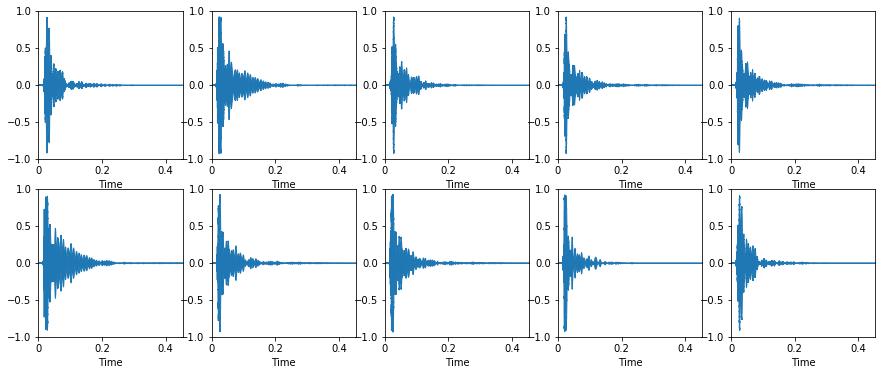

In [6]:
plt.figure(figsize=(15, 6))
for i, x in enumerate(kick_signals):
    plt.subplot(2, 5, i+1)
    librosa.display.waveplot(x[:10000])
    plt.ylim(-1, 1)

#### Display the snare drum signals:

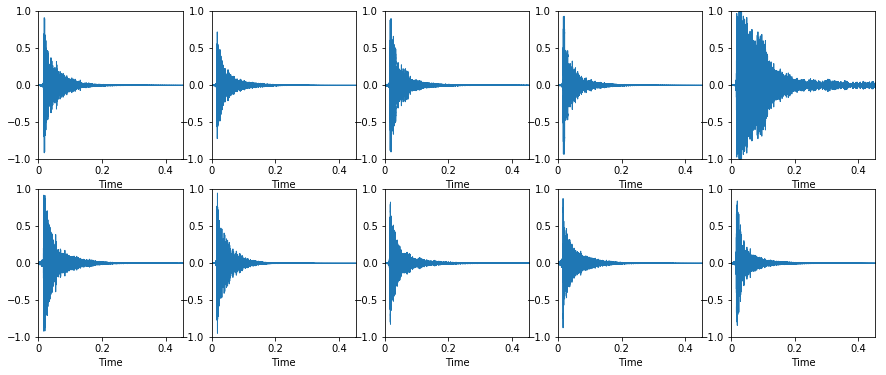

In [7]:
plt.figure(figsize=(15, 6))
for i, x in enumerate(snare_signals):
    plt.subplot(2, 5, i+1)
    librosa.display.waveplot(x[:10000])
    plt.ylim(-1, 1)

## Feature Vectors

* A **feature** is a variable
* A **feature vector** is observed values of a feature
* Think column in a table
    * Each column = One feature
    * Each row = One individual

## Constructing a Feature Vector

Feature extraction roadmap

We will write functions to 

1. Extract features from one observation
2. Extract features from many observations

#### Extract features from one observation

In [8]:
def extract_features_row(signal):
    return [librosa.feature.zero_crossing_rate(signal)[0, 0],
            librosa.feature.spectral_centroid(signal)[0, 0]]

#### Extract featues from many observations

In [9]:
def extract_features(signals):
    return numpy.array([extract_features_row(x) for x in signals])

#### Construct features for kick drum and snare drum samples

In [10]:
kick_features = extract_features(kick_signals)
snare_features = extract_features(snare_signals)

#### Unstacked pandas table

In [11]:
import pandas as pd
features = pd.DataFrame({'kick_zero_crossing' : kick_features[:,0],
                         'kick_centroid'       : kick_features[:,1],
                         'snare_zero_crossing' : snare_features[:,0],
                         'snare_centroid'      :  snare_features[:,1]})
features.head()

,kick_zero_crossing,kick_centroid,snare_zero_crossing,snare_centroid
0,0.075195,1429.552428,0.113281,2491.930652
1,0.072754,1756.679850,0.106445,2073.156275
2,0.067871,1139.892205,0.089844,2734.785771
3,0.066406,1095.467659,0.092773,2309.215285
4,0.069336,1153.091834,0.117188,2497.791429


#### Visualize the differences in features by plotting separate histograms for each of the classes:

/Users/tiverson/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


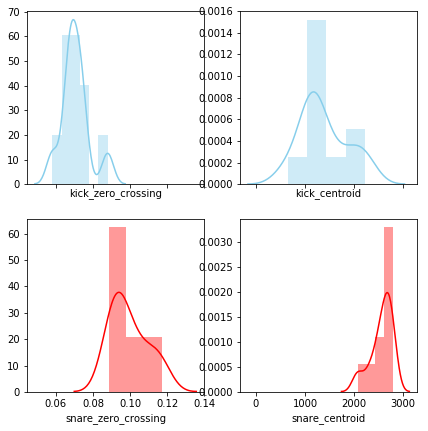

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
features = pd.DataFrame({'kick_zero_crossing' : kick_features[:,0],
                         'kick_centroid'       : kick_features[:,1],
                         'snare_zero_crossing' : snare_features[:,0],
                         'snare_centroid'      :  snare_features[:,1]})

f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex='col')
sns.distplot(features['kick_zero_crossing' ], color="skyblue", ax=axes[0, 0])
sns.distplot(features['kick_centroid'      ], color="skyblue", ax=axes[0, 1])
sns.distplot(features['snare_zero_crossing'], color="red",    ax=axes[1, 0])
sns.distplot(features['snare_centroid'     ], color="red",    ax=axes[1, 1])

## Feature Scaling

* The features are on different scales
    * $0.02 < zero-crossing < 0.14$
    * $0 < centroid < 3000$
* **Problem:** Cause issues with classification algorithms
* **Solution:** Scale the features to the same range

## Using `MinMaxScaler`

* [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).  
* `MinMaxScaler` scales each feature to a range -1 to 1.

#### Stack the feature vectors

In [18]:
from itertools import repeat
feature_table = numpy.vstack((kick_features, snare_features))
features.head()

,kick_zero_crossing,kick_centroid,snare_zero_crossing,snare_centroid
0,0.075195,1429.552428,0.113281,2491.930652
1,0.072754,1756.679850,0.106445,2073.156275
2,0.067871,1139.892205,0.089844,2734.785771
3,0.066406,1095.467659,0.092773,2309.215285
4,0.069336,1153.091834,0.117188,2497.791429


#### Scale the feature vector

In [19]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
training_features = scaler.fit_transform(feature_table)
training_features[:5,]

array([[-0.4214876 , -0.2729327 ],
       [-0.50413223,  0.03043368],
       [-0.66942149, -0.54155333],
       [-0.71900826, -0.58275108],
       [-0.61983471, -0.52931247]])

#### Stacked pandas table

In [20]:
from itertools import repeat
stacked_features = pd.DataFrame({'class': np.array((['kick' for i in range(10)]) + 
                                                    ['snare' for i in range(10)]),
                                 'zero_crossing' : training_features[:,0],
                                 'centroid' : training_features[:,1]})
stacked_features.head()

,class,zero_crossing,centroid
0,kick,-0.421488,-0.272933
1,kick,-0.504132,0.030434
2,kick,-0.669421,-0.541553
3,kick,-0.719008,-0.582751
4,kick,-0.619835,-0.529312


Scale each feature dimension to be in the range -1 to 1:

In [21]:
stacked_features['class']

0      kick
1      kick
2      kick
3      kick
4      kick
5      kick
6      kick
7      kick
8      kick
9      kick
10    snare
11    snare
12    snare
13    snare
14    snare
15    snare
16    snare
17    snare
18    snare
19    snare
Name: class, dtype: object

Plot the scaled features:

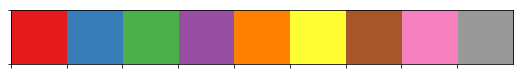

In [22]:
sns.palplot(sns.color_palette("Set1"))

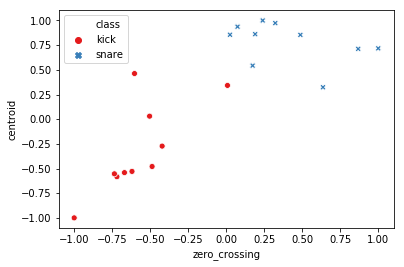

In [23]:
sns.scatterplot(x="zero_crossing", 
                y="centroid", 
                hue="class", 
                style = 'class',
                palette = sns.color_palette("Set1", n_colors=2),
                data=stacked_features)

## The next step ... take DSCI 425!

* Classification is a DSCI 425 topic
* Example
    * Use a support vector machine to trail a classifier

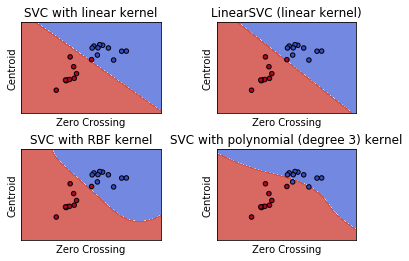

In [24]:
#Code adapted from https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


X = training_features
y = [1 if cls == 'kick' else 0 for cls in stacked_features['class']]
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Zero Crossing')
    ax.set_ylabel('Centroid')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)